# Converting Navier-Stokes Spectral Data to Well Format

This notebook demonstrates how to convert Navier-Stokes spectral simulation data to the Well format on the fly for use with Walrus.

## Overview

**Input Data Format:**
- Individual fields with shape `[B, Nt, Nx, Ny]` where:
  - `B` = number of simulations/trajectories
  - `Nt` = time steps
  - `Nx, Ny` = spatial dimensions
- Fields: horizontal velocity (u), vertical velocity (v), pressure (p), density (ρ)

**Output: Well Format**
- Organized HDF5 structure with metadata
- Fields organized by tensor rank (t0_fields for scalars, t1_fields for vectors)
- Velocity components stacked as `[B, Nt, Nx, Ny, 2]`
- Boundary conditions specified
- Compatible with Walrus data loading pipeline

## Step 1: Import Libraries

In [1]:
import numpy as np
import torch
import h5py
import os
from pathlib import Path

print("Libraries imported successfully")

Libraries imported successfully


## Step 2: Load Navier-Stokes Data

Load the spectral Navier-Stokes data from the .npz files. The data loader returns:
- Velocity fields (u, v) already stacked
- Pressure field (p)
- Spatial coordinates (x, y)
- Time step (dt)

In [4]:
def Navier_Stokes_Spectral(n_sims, data_dist):
    """
    Load Navier-Stokes spectral simulation data.
    
    Args:
        n_sims: Number of simulations to load
        data_dist: 'ID' for in-distribution or 'OOD' for out-of-distribution
    
    Returns:
        u: Horizontal velocity [B, Nt, Nx, Ny]
        v: Vertical velocity [B, Nt, Nx, Ny]
        p: Pressure [B, Nt, Nx, Ny]
        rho: Density [B, Nt, Nx, Ny]
        x: X-coordinates
        y: Y-coordinates  
        dt: Time step
    """
    data_loc = '/Users/Vicky/Documents/UKAEA/Code/Uncertainty_Quantification/PDE_Residuals/Neural_PDE/Data'
    
    # Load appropriate dataset based on distribution
    if data_dist == 'ID':
        data = np.load(data_loc + '/NS_Spectral_combined.npz')
    elif data_dist == 'OOD':
        data = np.load(data_loc + '/NS_Spectral_combined_pitagora_OOD_nu_1e-2.npz')

    # Extract fields and convert to float32
    u = data['u'].astype(np.float32)[:n_sims]  # Horizontal velocity [B, Nt, Nx, Ny]
    v = data['v'].astype(np.float32)[:n_sims]  # Vertical velocity [B, Nt, Nx, Ny]
    p = data['p'].astype(np.float32)[:n_sims]  # Pressure [B, Nt, Nx, Ny]
    rho = np.ones_like(u)  # Density = 1 (constant)
    
    # Extract coordinates and time step
    x = data['x']
    y = x  # Assuming square domain
    dt = data['dt']

    return u, v, p, rho, x, y, dt

In [5]:
# Load a small subset for demonstration
n_sims = 5  # Number of simulations to convert
data_dist = 'ID'  # or 'OOD'

# Load the data - now returns individual velocity components
u, v, p, rho, x_coords, y_coords, dt = Navier_Stokes_Spectral(n_sims, data_dist)

print(f"Loaded data shapes:")
print(f"  Horizontal velocity (u): {u.shape}  # [B, Nt, Nx, Ny]")
print(f"  Vertical velocity (v): {v.shape}    # [B, Nt, Nx, Ny]")
print(f"  Pressure (p): {p.shape}              # [B, Nt, Nx, Ny]")
print(f"  Density (rho): {rho.shape}           # [B, Nt, Nx, Ny]")
print(f"  X coordinates: {x_coords.shape}")
print(f"  Y coordinates: {y_coords.shape}")
print(f"  Time step: {dt}")

Loaded data shapes:
  Horizontal velocity (u): (5, 50, 100, 100)  # [B, Nt, Nx, Ny]
  Vertical velocity (v): (5, 50, 100, 100)    # [B, Nt, Nx, Ny]
  Pressure (p): (5, 50, 100, 100)              # [B, Nt, Nx, Ny]
  Density (rho): (5, 50, 100, 100)           # [B, Nt, Nx, Ny]
  X coordinates: (100,)
  Y coordinates: (100,)
  Time step: 0.01


## Step 3: Understand the Data Structure

Let's examine the data to understand what we're working with:
- **Spatial dimensions**: Nx × Ny grid
- **Time steps**: Nt snapshots
- **Fields**:
  - Velocity: vector field (u, v) → goes in `t1_fields`
  - Pressure: scalar field (p) → goes in `t0_fields`
  - Density: scalar field (ρ) → goes in `t0_fields`

In [6]:
# Extract dimensions
B, Nt, Nx, Ny = u.shape
print(f"Data dimensions:")
print(f"  Number of trajectories (B): {B}")
print(f"  Time steps (Nt): {Nt}")
print(f"  Spatial grid: {Nx} × {Ny}")
print(f"\nSpatial resolution:")
print(f"  X range: [{x_coords.min():.2f}, {x_coords.max():.2f}]")
print(f"  Y range: [{y_coords.min():.2f}, {y_coords.max():.2f}]")

Data dimensions:
  Number of trajectories (B): 5
  Time steps (Nt): 50
  Spatial grid: 100 × 100

Spatial resolution:
  X range: [0.00, 0.99]
  Y range: [0.00, 0.99]


## Step 4: Define Conversion Function

This function converts the Navier-Stokes data to Well format. Key transformations:

1. **Stack velocity components**: Combine u and v into a single array `[B, Nt, Nx, Ny, 2]`
2. **Field organization**: Separate scalars (pressure, density) and vectors (velocity)
3. **Metadata**: Add boundary conditions, dimensions, and field attributes
4. **Boundary conditions**: For spectral methods, typically PERIODIC in all directions

In [7]:
def convert_ns_to_well(u, v, pressure, density, x_coords, y_coords, dt, output_path, 
                       dataset_name="navier_stokes_spectral", boundary_type="PERIODIC"):
    """
    Convert Navier-Stokes spectral data to Well format.
    
    Args:
        u: Array [B, Nt, Nx, Ny] - horizontal velocity
        v: Array [B, Nt, Nx, Ny] - vertical velocity
        pressure: Array [B, Nt, Nx, Ny] - pressure field
        density: Array [B, Nt, Nx, Ny] - density field
        x_coords: Array [Nx] - x-coordinates
        y_coords: Array [Ny] - y-coordinates
        dt: Scalar or array - time step(s)
        output_path: String - path for output HDF5 file
        dataset_name: String - name for the dataset
        boundary_type: String - 'PERIODIC', 'WALL', or 'OPEN'
    """
    
    # ============================================================
    # STEP 1: Extract dimensions and prepare data
    # ============================================================
    
    B, Nt, Nx, Ny = u.shape
    
    # Convert to numpy if needed
    if isinstance(u, torch.Tensor):
        u = u.numpy()
    if isinstance(v, torch.Tensor):
        v = v.numpy()
    if isinstance(dt, torch.Tensor):
        dt = dt.numpy()
    
    # Stack velocity components: [B, Nt, Nx, Ny, 2]
    # Well format expects: [trajectory, time, x, y, components]
    # Stack as [u, v] for correct horizontal/vertical ordering
    velocity = np.stack([u, v], axis=-1)  # [B, Nt, Nx, Ny, 2]
    
    # Scalar fields are already in correct order: [B, Nt, Nx, Ny]
    # No transposition needed for pressure and density
    
    # Create time array
    # Handle both scalar dt and array dt
    if np.ndim(dt) == 0 or (isinstance(dt, np.ndarray) and dt.size == 1):
        # dt is a scalar
        dt_value = float(dt)
        time = np.arange(Nt) * dt_value
    else:
        # dt is an array of time steps
        time = np.cumsum(np.concatenate([[0], dt[:-1]]))
    
    print(f"Converted shapes:")
    print(f"  Velocity: {velocity.shape}  # [B, Nt, Nx, Ny, 2]")
    print(f"  Pressure: {pressure.shape}  # [B, Nt, Nx, Ny]")
    print(f"  Density: {density.shape}   # [B, Nt, Nx, Ny]")
    
    # ============================================================
    # STEP 2: Create Well-formatted HDF5 file
    # ============================================================
    
    with h5py.File(output_path, 'w') as f:
        
        # ------------------------------------------------------------
        # 2a. Top-level metadata attributes
        # ------------------------------------------------------------
        f.attrs["dataset_name"] = dataset_name
        f.attrs["grid_type"] = "cartesian"
        f.attrs["n_spatial_dims"] = 2  # 2D simulation
        f.attrs["n_trajectories"] = B   # Number of independent simulations
        
        # ------------------------------------------------------------
        # 2b. Dimensions group
        # Contains coordinate arrays and dimension metadata
        # ------------------------------------------------------------
        dims = f.create_group("dimensions")
        dims.attrs["spatial_dims"] = ["x", "y"]  # Names of spatial dimensions
        
        # Time dimension
        time_dset = dims.create_dataset("time", data=time)
        time_dset.attrs["time_varying"] = True    # Changes with time (obviously)
        time_dset.attrs["sample_varying"] = False  # Same for all trajectories
        
        # Spatial dimensions
        x_dset = dims.create_dataset("x", data=x_coords)
        x_dset.attrs["time_varying"] = False
        x_dset.attrs["sample_varying"] = False
        
        y_dset = dims.create_dataset("y", data=y_coords)
        y_dset.attrs["time_varying"] = False
        y_dset.attrs["sample_varying"] = False
        
        # ------------------------------------------------------------
        # 2c. Boundary conditions group
        # For spectral methods, typically PERIODIC in all directions
        # ------------------------------------------------------------
        boundaries = f.create_group("boundary_conditions")
        
        # Map boundary type string to integer code
        bc_type_map = {"WALL": 0, "OPEN": 1, "PERIODIC": 2}
        bc_code = bc_type_map.get(boundary_type, 2)  # Default to PERIODIC
        
        # X-direction boundary
        x_bc = boundaries.create_group(f"x_{boundary_type.lower()}")
        x_mask = np.zeros(Nx, dtype=np.int8)
        if boundary_type != "PERIODIC":
            x_mask[0] = 1   # Lower boundary
            x_mask[-1] = 1  # Upper boundary
        else:
            x_mask[:] = 1   # All points affected by periodic BC
        x_bc.create_dataset("mask", data=x_mask, dtype=np.int8)
        x_bc.attrs["bc_type"] = boundary_type
        
        # Y-direction boundary
        y_bc = boundaries.create_group(f"y_{boundary_type.lower()}")
        y_mask = np.zeros(Ny, dtype=np.int8)
        if boundary_type != "PERIODIC":
            y_mask[0] = 1
            y_mask[-1] = 1
        else:
            y_mask[:] = 1
        y_bc.create_dataset("mask", data=y_mask, dtype=np.int8)
        y_bc.attrs["bc_type"] = boundary_type
        
        # ------------------------------------------------------------
        # 2d. Scalars group (simulation parameters)
        # These are 0D parameters that don't vary in space or time
        # ------------------------------------------------------------
        scalars = f.create_group("scalars")
        
        # Store time step as a scalar parameter
        dt_value = float(dt) if np.ndim(dt) == 0 or dt.size == 1 else float(dt.mean())
        dt_scalar = scalars.create_dataset("dt", data=dt_value)
        dt_scalar.attrs["description"] = "Time step"
        dt_scalar.attrs["time_varying"] = False
        dt_scalar.attrs["sample_varying"] = False
        
        # ------------------------------------------------------------
        # 2e. t0_fields group (SCALAR fields)
        # Shape: [trajectory, time, x, y]
        # Contains: pressure, density
        # ------------------------------------------------------------
        t0 = f.create_group("t0_fields")
        t0.attrs["field_names"] = ["pressure", "density"]
        
        # Pressure field
        p_dset = t0.create_dataset("pressure", data=pressure, compression="gzip")
        p_dset.attrs["dim_varying"] = np.array([True, True])  # Varies in both x and y
        p_dset.attrs["sample_varying"] = True   # Different for each trajectory
        p_dset.attrs["time_varying"] = True     # Changes over time
        p_dset.attrs["description"] = "Pressure field"
        
        # Density field
        rho_dset = t0.create_dataset("density", data=density, compression="gzip")
        rho_dset.attrs["dim_varying"] = np.array([True, True])
        rho_dset.attrs["sample_varying"] = True
        rho_dset.attrs["time_varying"] = True
        rho_dset.attrs["description"] = "Density field"
        
        # ------------------------------------------------------------
        # 2f. t1_fields group (VECTOR fields)
        # Shape: [trajectory, time, x, y, components]
        # Contains: velocity (u, v)
        # ------------------------------------------------------------
        t1 = f.create_group("t1_fields")
        t1.attrs["field_names"] = ["velocity"]
        
        # Velocity field
        v_dset = t1.create_dataset("velocity", data=velocity, compression="gzip")
        v_dset.attrs["dim_varying"] = np.array([True, True])  # Varies in both x and y
        v_dset.attrs["sample_varying"] = True
        v_dset.attrs["time_varying"] = True
        v_dset.attrs["description"] = "Velocity field (u, v)"
        v_dset.attrs["components"] = ["u", "v"]  # Component names
        
        # ------------------------------------------------------------
        # 2g. t2_fields group (TENSOR fields)
        # Shape: [trajectory, time, x, y, i, j]
        # Empty for this dataset (no stress/strain tensors)
        # ------------------------------------------------------------
        t2 = f.create_group("t2_fields")
        t2.attrs["field_names"] = []  # No tensor fields in this dataset
    
    print(f"\n✓ Successfully converted to Well format: {output_path}")
    print(f"  Dataset: {dataset_name}")
    print(f"  Trajectories: {B}")
    print(f"  Time steps: {Nt}")
    print(f"  Grid: {Nx} × {Ny}")
    print(f"  Boundary conditions: {boundary_type}")

## Step 5: Convert Data to Well Format

Now we'll convert our loaded Navier-Stokes data to the Well format and save it as an HDF5 file.

In [8]:
# Define output directory and filename
output_dir = Path("./converted_data")
output_dir.mkdir(exist_ok=True)

output_path = output_dir / f"navier_stokes_spectral_{data_dist.lower()}_n{n_sims}.hdf5"

# Convert the data - now pass individual velocity components
convert_ns_to_well(
    u=u,
    v=v,
    pressure=p,
    density=rho,
    x_coords=x_coords,
    y_coords=y_coords,
    dt=dt,
    output_path=str(output_path),
    dataset_name=f"navier_stokes_spectral_{data_dist}",
    boundary_type="PERIODIC"  # Spectral methods typically use periodic BCs
)

Converted shapes:
  Velocity: (5, 50, 100, 100, 2)  # [B, Nt, Nx, Ny, 2]
  Pressure: (5, 50, 100, 100)  # [B, Nt, Nx, Ny]
  Density: (5, 50, 100, 100)   # [B, Nt, Nx, Ny]

✓ Successfully converted to Well format: converted_data/navier_stokes_spectral_id_n5.hdf5
  Dataset: navier_stokes_spectral_ID
  Trajectories: 5
  Time steps: 50
  Grid: 100 × 100
  Boundary conditions: PERIODIC


## Step 6: Verify the Converted Data

Let's verify that our converted file is correctly formatted by:
1. Examining the HDF5 structure
2. Checking shapes and attributes
3. Visualizing a sample field

In [9]:
def print_hdf5_structure(file_path, indent=0):
    """
    Recursively print the structure of an HDF5 file.
    """
    with h5py.File(file_path, 'r') as f:
        def print_attrs(name, obj):
            """Print attributes of an HDF5 object."""
            prefix = "  " * indent
            if isinstance(obj, h5py.Dataset):
                print(f"{prefix}├── {name} {obj.shape} {obj.dtype}")
            else:
                print(f"{prefix}├── {name}/")
            
            # Print attributes
            for key, val in obj.attrs.items():
                print(f"{prefix}│   └── @{key}: {val}")
        
        print(f"\nHDF5 Structure: {file_path}")
        print("="*60)
        
        # Print top-level attributes
        print("Top-level attributes:")
        for key, val in f.attrs.items():
            print(f"  @{key}: {val}")
        print()
        
        # Print structure
        f.visititems(print_attrs)

# Print the structure
print_hdf5_structure(output_path)


HDF5 Structure: converted_data/navier_stokes_spectral_id_n5.hdf5
Top-level attributes:
  @dataset_name: navier_stokes_spectral_ID
  @grid_type: cartesian
  @n_spatial_dims: 2
  @n_trajectories: 5

├── boundary_conditions/
├── boundary_conditions/x_periodic/
│   └── @bc_type: PERIODIC
├── boundary_conditions/x_periodic/mask (100,) int8
├── boundary_conditions/y_periodic/
│   └── @bc_type: PERIODIC
├── boundary_conditions/y_periodic/mask (100,) int8
├── dimensions/
│   └── @spatial_dims: ['x' 'y']
├── dimensions/time (50,) float64
│   └── @sample_varying: False
│   └── @time_varying: True
├── dimensions/x (100,) float64
│   └── @sample_varying: False
│   └── @time_varying: False
├── dimensions/y (100,) float64
│   └── @sample_varying: False
│   └── @time_varying: False
├── scalars/
├── scalars/dt () float64
│   └── @description: Time step
│   └── @sample_varying: False
│   └── @time_varying: False
├── t0_fields/
│   └── @field_names: ['pressure' 'density']
├── t0_fields/density (5, 50, 

In [10]:
# Verify shapes and load a sample
with h5py.File(output_path, 'r') as f:
    print("\nField shapes:")
    print(f"  Velocity: {f['t1_fields/velocity'].shape}")
    print(f"  Pressure: {f['t0_fields/pressure'].shape}")
    print(f"  Density: {f['t0_fields/density'].shape}")
    
    print("\nBoundary conditions:")
    for bc_name in f['boundary_conditions'].keys():
        bc_type = f[f'boundary_conditions/{bc_name}'].attrs['bc_type']
        print(f"  {bc_name}: {bc_type}")
    
    print("\nDimensions:")
    print(f"  Time: {f['dimensions/time'].shape} - {f['dimensions/time'][:5]}...")
    print(f"  X: {f['dimensions/x'].shape}")
    print(f"  Y: {f['dimensions/y'].shape}")


Field shapes:
  Velocity: (5, 50, 100, 100, 2)
  Pressure: (5, 50, 100, 100)
  Density: (5, 50, 100, 100)

Boundary conditions:
  x_periodic: PERIODIC
  y_periodic: PERIODIC

Dimensions:
  Time: (50,) - [0.   0.01 0.02 0.03 0.04]...
  X: (100,)
  Y: (100,)


## Step 7: Visualize Converted Data

Let's visualize one of the converted fields to ensure everything looks correct.

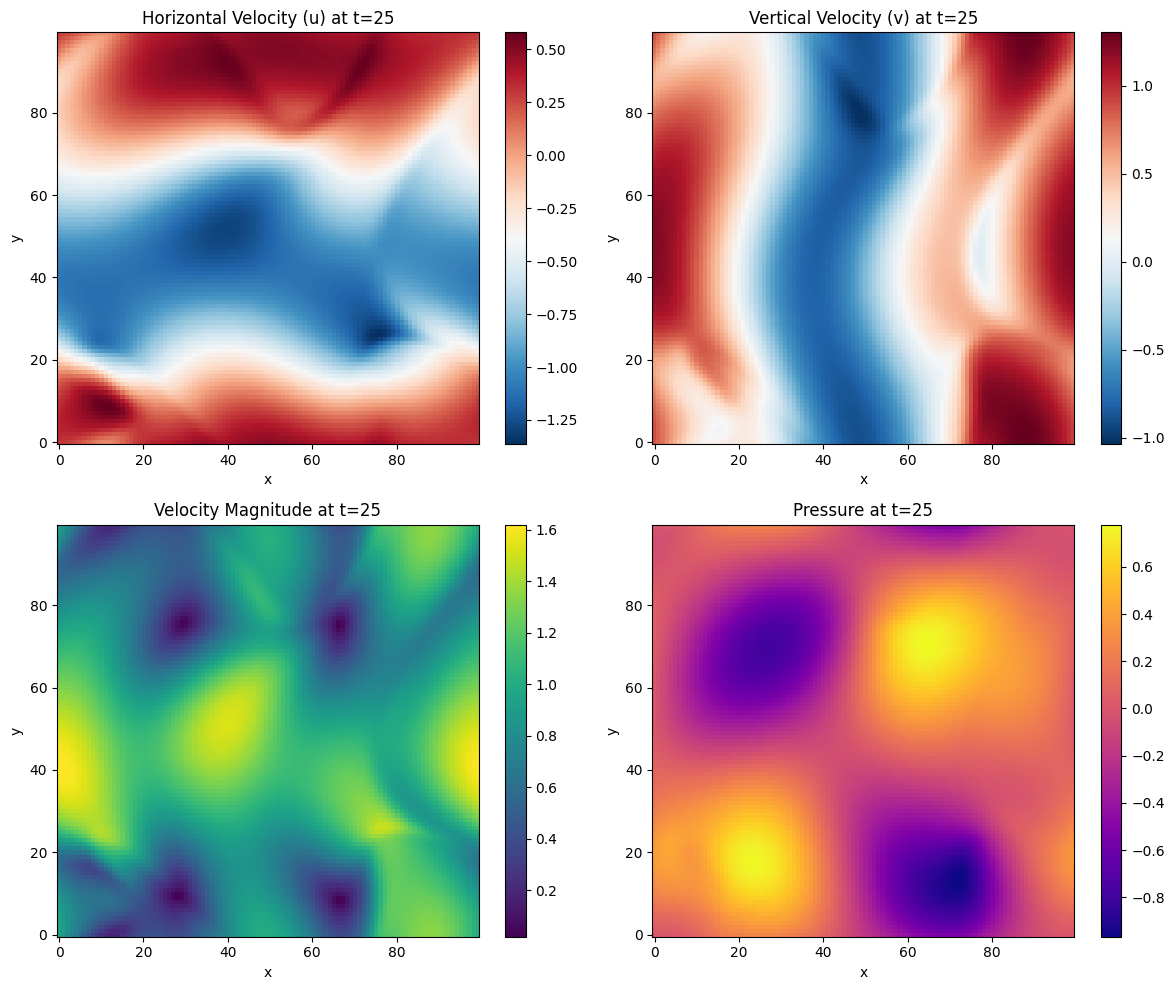


Visualized trajectory 0, timestep 25/50


In [13]:
import matplotlib.pyplot as plt

# Load and visualize a sample timestep
with h5py.File(output_path, 'r') as f:
    # Load data for first trajectory, middle timestep
    traj_idx = 0
    time_idx = Nt // 2
    
    velocity = f['t1_fields/velocity'][traj_idx, time_idx, :, :, :]  # [Nx, Ny, 2]
    pressure = f['t0_fields/pressure'][traj_idx, time_idx, :, :]     # [Nx, Ny]
    
    u = velocity[:, :, 0]  # Horizontal velocity
    v = velocity[:, :, 1]  # Vertical velocity
    
    # Compute velocity magnitude
    vel_mag = np.sqrt(u**2 + v**2)

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Horizontal velocity
im0 = axes[0, 0].imshow(u, origin='lower', cmap='RdBu_r', aspect='auto')
axes[0, 0].set_title(f'Horizontal Velocity (u) at t={time_idx}')
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('y')
plt.colorbar(im0, ax=axes[0, 0])

# Vertical velocity
im1 = axes[0, 1].imshow(v, origin='lower', cmap='RdBu_r', aspect='auto')
axes[0, 1].set_title(f'Vertical Velocity (v) at t={time_idx}')
axes[0, 1].set_xlabel('x')
axes[0, 1].set_ylabel('y')
plt.colorbar(im1, ax=axes[0, 1])

# Velocity magnitude
im2 = axes[1, 0].imshow(vel_mag, origin='lower', cmap='viridis', aspect='auto')
axes[1, 0].set_title(f'Velocity Magnitude at t={time_idx}')
axes[1, 0].set_xlabel('x')
axes[1, 0].set_ylabel('y')
plt.colorbar(im2, ax=axes[1, 0])

# Pressure
im3 = axes[1, 1].imshow(pressure, origin='lower', cmap='plasma', aspect='auto')
axes[1, 1].set_title(f'Pressure at t={time_idx}')
axes[1, 1].set_xlabel('x')
axes[1, 1].set_ylabel('y')
plt.colorbar(im3, ax=axes[1, 1])

plt.tight_layout()
plt.show()

print(f"\nVisualized trajectory {traj_idx}, timestep {time_idx}/{Nt}")

## Step 8: Batch Conversion (Optional)

For converting multiple files or larger datasets, you can use this batch conversion function.

In [ ]:
def batch_convert_ns_to_well(n_sims_list, data_dists, output_base_dir="./converted_data"):
    """
    Convert multiple Navier-Stokes datasets to Well format.
    
    Args:
        n_sims_list: List of integers - number of simulations to load for each conversion
        data_dists: List of strings - 'ID' or 'OOD' for each conversion
        output_base_dir: Base directory for output files
    """
    output_dir = Path(output_base_dir)
    output_dir.mkdir(exist_ok=True)
    
    converted_files = []
    
    for n_sims, data_dist in zip(n_sims_list, data_dists):
        print(f"\n{'='*60}")
        print(f"Converting {data_dist} dataset with {n_sims} simulations...")
        print(f"{'='*60}")
        
        # Load data
        u, v, p, rho, x_coords, y_coords, dt = Navier_Stokes_Spectral(n_sims, data_dist)
        
        # Define output path
        output_path = output_dir / f"navier_stokes_spectral_{data_dist.lower()}_n{n_sims}.hdf5"
        
        # Convert
        convert_ns_to_well(
            u=u,
            v=v,
            pressure=p,
            density=rho,
            x_coords=x_coords,
            y_coords=y_coords,
            dt=dt,
            output_path=str(output_path),
            dataset_name=f"navier_stokes_spectral_{data_dist}",
            boundary_type="PERIODIC"
        )
        
        converted_files.append(str(output_path))
    
    print(f"\n{'='*60}")
    print(f"Batch conversion complete!")
    print(f"{'='*60}")
    print(f"\nConverted files:")
    for f in converted_files:
        print(f"  - {f}")
    
    return converted_files

In [ ]:
# Example: Convert multiple datasets
# Uncomment to run

# converted_files = batch_convert_ns_to_well(
#     n_sims_list=[10, 10],           # Number of simulations for each dataset
#     data_dists=['ID', 'OOD'],       # Distribution types
#     output_base_dir="./converted_data"
# )

## Step 9: Load Converted Data with Walrus DataModule (Optional)

Once converted, you can load the data using Walrus's data loading infrastructure.

In [ ]:
# This requires the Walrus library to be installed
# Uncomment to use with Walrus

# from walrus.data.datamodule import WalrusDataModule
# from hydra import compose, initialize
# from omegaconf import OmegaConf

# # Load Walrus configuration
# with initialize(version_base=None, config_path="../configs"):
#     cfg = compose(config_name="extended_config")

# # Update config to point to your converted data
# cfg.data.well_base_path = str(output_dir)

# # Create data module
# data_module = WalrusDataModule(
#     well_base_path=str(output_dir),
#     batch_size=2,
#     num_workers=0,
#     # ... other parameters
# )

# data_module.setup()
# print(f"Loaded {len(data_module.rollout_val_datasets)} datasets")

## Summary

This notebook demonstrated how to convert Navier-Stokes spectral simulation data to the Well format:

### What We Did:
✓ Loaded Navier-Stokes data with separate u, v, p, ρ fields in `[B, Nt, Nx, Ny]` format  
✓ Stacked velocity components (u, v) in the conversion pipeline  
✓ Separated scalar fields (pressure, density) and vector fields (velocity)  
✓ Created properly structured HDF5 file with metadata  
✓ Added boundary conditions (PERIODIC for spectral methods)  
✓ Verified the converted data structure  
✓ Visualized the converted fields  

### Key Transformations:
- **Input**: Individual fields `u, v, p, ρ` each with shape `[B, Nt, Nx, Ny]`
- **Velocity stacking**: `np.stack([u, v], axis=-1)` → `[B, Nt, Nx, Ny, 2]` in t1_fields
- **Scalars**: Already in correct format `[B, Nt, Nx, Ny]` for t0_fields

### Next Steps:
1. **Use with Walrus**: Load the converted data with `WalrusDataModule`
2. **Run inference**: Use the data for model rollout predictions
3. **Train models**: Fine-tune Walrus on your converted dataset
4. **Batch conversion**: Convert your full dataset using the batch function

### Notes:
- Spectral methods typically use **PERIODIC** boundary conditions
- If your data has different BCs, modify the `boundary_type` parameter
- The conversion preserves all physical fields and their time evolution
- Compression is enabled to reduce file size
- Velocity stacking happens in the conversion function, keeping the data loader simple